
(sphx_glr_topic_vta_tutorials_frontend_deploy_classification.py)=
# 在 VTA 上从 MxNet 部署预训练的视觉模型

**Author**: [Thierry Moreau](https://homes.cs.washington.edu/~moreau/)

本教程提供了端到端的 demo，介绍了如何在 VTA 加速器设计上运行 ImageNet 分类推理来执行 ImageNet 分类任务。它将 Relay 展示为前端编译器，它可以执行量化（VTA 只支持 int8/32 推理）和 graph packing（以便在 core 中支持张量化），从而为硬件目标处理计算图。

## 安装依赖

要在 `tvm` 中使用 `autovm` 包，需要安装一些额外的依赖项。（如果你使用 python2，将 "3" 改为 "2"）：

```shell
pip3 install --user mxnet requests "Pillow<7"
```

现在回到 python 代码。导入包。


In [1]:
import os, time
from PIL import Image

from mxnet.gluon.model_zoo import vision
import numpy as np
from matplotlib import pyplot as plt

import tvm
import logging
from tvm.ir.transform import PassContext
from tvm import rpc, autotvm, relay
from tvm.contrib import graph_executor, utils, download
# from tvm.contrib.debugger import debug_executor
# from tvm.relay import transform

import vta
from vta.testing import simulator
from vta.top import graph_pack

# Make sure that TVM was compiled with RPC=1
assert tvm.runtime.enabled("rpc")

## 定义 platform

在 CPU 和 VTA 上执行，并定义模型。

从 `3rdparty/vta-hw/config/vta_config.json` 文件加载 VTA 参数：

In [2]:
env = vta.get_env()

设定设备：

1. 在 CPU 上推理，使用 ``device=arm_cpu``
2. 在 FPGA 上推理，使用 ``device=vta``

In [3]:
ctx = "vta"

用于查找何时 start/end bit packing 的字典：

In [4]:
pack_dict = {
    "resnet18_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet34_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet34_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet50_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet101_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
}

```{note}
``start_pack`` 和 ``stop_pack`` 标签指示从哪里开始和结束 graph packing relay pass：换句话说，从哪里开始和结束 VTA 卸载。
```

设定运行目标设备：

In [5]:
target = env.target if ctx == "vta" else env.target_vta_cpu

## 获取远程执行

当 `env.TARGET` 为 `'pynq'` 时，重新配置 FPGA 和 runtime。否则，如果 `env.TARGET` 为 `'sim'`，则在本地执行。

In [6]:
if env.TARGET not in ["sim", "tsim", "intelfocl"]:
    # 如果设置环境变量，从 tracker 节点获取 remote。
    # 要设置 tracker，您需要遵循“自动调优卷积网络用于 VTA ”教程。
    tracker_host = os.environ.get("TVM_TRACKER_HOST", None)
    tracker_port = os.environ.get("TVM_TRACKER_PORT", None)
    # 否则，如果你有设备，你想直接从 host 编程，
    # 确保你已经设置了下面的变量为你的板的 IP。
    device_host = os.environ.get("VTA_RPC_HOST", "192.168.2.99")
    device_port = os.environ.get("VTA_RPC_PORT", "9091")
    if not tracker_host or not tracker_port:
        remote = rpc.connect(device_host, int(device_port))
    else:
        remote = autotvm.measure.request_remote(
            env.TARGET, 
            tracker_host, 
            int(tracker_port), 
            timeout=10000
        )

    # 重新配置 JIT 运行时和 FPGA。
    # 通过将路径传递给 bitstream 文件而不是 None，
    # 您可以使用自己的自定义 bitstream 编程 FPGA。
    reconfig_start = time.time()
    vta.reconfig_runtime(remote)
    vta.program_fpga(remote, bitstream=None)
    reconfig_time = time.time() - reconfig_start
    print(f"Reconfigured FPGA and RPC runtime in {reconfig_time:.2f}s!")
# 在仿真模式中，在本地托管 RPC 服务器。
else:
    remote = rpc.LocalSession()
    if env.TARGET in ["intelfocl"]:
        # program intelfocl aocx
        vta.program_fpga(remote, bitstream="vta.bitstream")

从远程获取执行上下文：

In [7]:
if env.TARGET == "intelfocl":
    ctxes = [remote.ext_dev(0), remote.cpu(0)]
else:
    # Graph runtime
    ctxes = remote.ext_dev(0) if ctx == "vta" else remote.cpu(0)

## 构建 graph executor 推理

从 Gluon 模型动物园抓取视觉模型，用 Relay 编译。编译步骤如下：

1. 将 MXNet 前端模块翻译为 Relay 模块。
2. 应用 8-bit 量化：这里跳过了第一个 conv 层和 dense 层，这两个层都将在 CPU 上的 fp32 中执行。
3. 执行  graph packing 来改变张量化的数据布局。
4. 进行常数折叠以减少算子的数量（例如，消除 batch norm multiply）。
5. 执行对 object 文件的 relay 构建。
6. 将 object 文件加载到远程（FPGA 设备）。

加载预配置的 AutoTVM 调度：

In [8]:
# 需要编译的模型名称
model = "resnet18_v1"
assert model in pack_dict
# 为 ImageNet 分类器输入填充 shape 和数据类型字典
dtype_dict = {"data": "float32"}
shape_dict = {"data": (env.BATCH, 3, 224, 224)}

# 取下 gluon 模型，转换成 relay
gluon_model = vision.get_model(model, pretrained=True)
with autotvm.tophub.context(target):
    # 度量构建的开始时间
    build_start = time.time()
    # 开始前端编译
    mod, params = relay.frontend.from_mxnet(gluon_model, shape_dict)
    # 更新 shape 和 type 字典
    shape_dict.update({k: v.shape for k, v in params.items()})
    dtype_dict.update({k: str(v.dtype) for k, v in params.items()})
    if target.device_name == "vta":
        # 在 Relay 中执行量化
        # 注意：为了 fold batch norm，将 `opt_level` 设置为 `3`
        with PassContext(opt_level=3):
            with relay.quantize.qconfig(global_scale=8.0,
                                        skip_conv_layers=[0]):
                mod = relay.quantize.quantize(mod, params=params)
            # 对 VTA target 进行 graph packing 和 constant folding
            assert env.BLOCK_IN == env.BLOCK_OUT
            # 如果目标是 intelfocl 或 sim，是否有 device annotation
            relay_prog = graph_pack(
                mod["main"],
                env.BATCH,
                env.BLOCK_OUT,
                env.WGT_WIDTH,
                start_name=pack_dict[model][0],
                stop_name=pack_dict[model][1],
                device_annot=(env.TARGET == "intelfocl"),
            )
    else:
        relay_prog = mod["main"]

    # 禁用 AlterOpLayout，编译 Relay 程序
    if target.device_name != "vta":
        with PassContext(opt_level=3,
                         disabled_pass={"AlterOpLayout"}):
            lib = relay.build(
                relay_prog,
                target=target,
                params=params
            )
    else:
        if env.TARGET == "intelfocl":
            # 在 CPU 和 VTA 上运行多个目标
            target = {"cpu": env.target_vta_cpu,
                      "ext_dev": target}
        with vta.build_config(
            opt_level=3,
            disabled_pass={"AlterOpLayout",
                           "tir.CommonSubexprElimTIR"}
        ):
            lib = relay.build(relay_prog,
                              target=target,
                              params=params)
    # 度量 Relay 构建时间
    build_time = time.time() - build_start
    logging.info(f"{model} inference graph built in {build_time:.2f}s!")

    # 将 inference library 发送到远程 RPC 服务器
    temp = utils.tempdir()
    lib.export_library(temp.relpath("graphlib.tar"))
    remote.upload(temp.relpath("graphlib.tar"))
    lib = remote.load_module("graphlib.tar")

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.
[21:26:45] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binder.cc:95: Warning: Trying to bind buffer to another one with lower alignment requirement  required_alignment=256, provided_alignment=64
[21:26:45] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binder.cc:95: Warning: Trying to bind buffer to another one with lower alignment requirement  required_alignment=256, provided_alignment=64
[21:26:46] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binder.cc:95: Warning: Trying to bind buffer to another one with lower alignment requirement  required_alignment=256, provided_alignment=64
[21:26:46] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binder.cc:95: Warning: Trying to bind buffer to another one with lower alignment requirement  required_alignment=256, provided_alignment=64
[21:26:46] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binde

## 进行图像分类推理

只需要下载 category 文件，`synset.txt` 和输入测试图像。

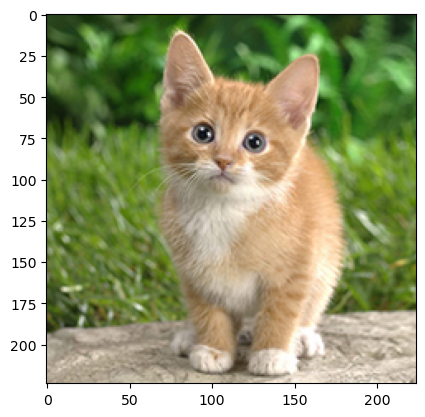

In [9]:
# 下载 ImageNet categories
categ_url = "https://github.com/uwsampl/web-data/raw/main/vta/models"
categ_fn = "synset.txt"
download.download(f"{categ_url}/{categ_fn}", categ_fn)
synset = eval(open(categ_fn).read())
# 下载测试图片
image_url = "https://homes.cs.washington.edu/~moreau/media/vta/cat.jpg"
image_fn = "cat.png"
download.download(image_url, image_fn)
# 准备用于推理的测试图像
image = Image.open(image_fn).resize((224, 224))
plt.imshow(image)
plt.show()
image = np.array(image) - np.array([123.0, 117.0, 104.0])
image /= np.array([58.395, 57.12, 57.375])
image = image.transpose((2, 0, 1))
image = image[np.newaxis, :]
image = np.repeat(image, env.BATCH, axis=0)

# 生成图执行器（graph executor） `m`。
m = graph_executor.GraphModule(lib["default"](ctxes))
# 设置网络参数和输入
m.set_input(**params)
m.set_input("data", image)

### 执行推理并收集执行统计信息

```{tip}
更多内容参考 {py:method}`tvm.runtime.Module.time_evaluator`。
```

In [10]:
num = 4  # 为单个度量运行模块的次数
rep = 3  # 测量的数量（由此得出 std dev）
timer = m.module.time_evaluator("run",
                                ctxes,
                                number=num,
                                repeat=rep)

if env.TARGET in ["sim", "tsim"]:
    simulator.clear_stats()
    timer()
    sim_stats = simulator.stats()
    print("\nExecution statistics:")
    for k, v in sim_stats.items():
        # 由于多次执行 workload，需要 normalize 统计数据。
        # 注意，总是有一次 warm up 运行
        # 因此，将整体统计数据除以 (num * rep + 1)
        print(f"\t{k:<16}: {v // (num * rep + 1):>16}")
else:
    tcost = timer()
    std = np.std(tcost.results) * 1000
    mean = tcost.mean * 1000
    print(f"\nPerformed inference in {mean:.2f}ms (std = {std:.2f}) for {env.BATCH} samples")
    print(f"Average per sample inference time: {mean / env.BATCH:.2f}ms")

# 得到的分类结果
tvm_output = m.get_output(0, tvm.nd.empty(
    (env.BATCH, 1000), "float32", remote.cpu(0)))
for b in range(env.BATCH):
    top_categories = np.argsort(tvm_output.numpy()[b])
    # 报告 top-5 分类结果
    print(f"\n{model} prediction for sample {b}")
    print("\t#1:", synset[top_categories[-1]])
    print("\t#2:", synset[top_categories[-2]])
    print("\t#3:", synset[top_categories[-3]])
    print("\t#4:", synset[top_categories[-4]])
    print("\t#5:", synset[top_categories[-5]])
    # 这只是检查 5 个顶级类别之一是一种猫；
    # 这绝不是对量化如何影响分类 accuracy 的准确评估，
    # 而是旨在捕捉在 CI 中会影响 accuracy 的量化传递的变化。
    cat_detected = False
    for k in top_categories[-5:]:
        if "cat" in synset[k]:
            cat_detected = True
    assert cat_detected

[21:26:59] /media/pc/data/lxw/ai/tvm/src/runtime/profiling.cc:101: Warning: No timer implementation for ext_dev, using default timer instead. It may be inaccurate or have extra overhead.



Execution statistics:
	inp_load_nbytes :          5549568
	wgt_load_nbytes :         12763136
	acc_load_nbytes :          6051840
	uop_load_nbytes :            22864
	out_store_nbytes:          2433536
	gemm_counter    :          6623232
	alu_counter     :           699328

resnet18_v1 prediction for sample 0
	#1: tiger cat
	#2: Egyptian cat
	#3: tabby, tabby cat
	#4: lynx, catamount
	#5: weasel
